# CSE 6040, Fall 2015 [25]: Logistic regression

Beyond regression, another important data analysis task is _classification_, in which you are given a set of labeled data points and you wish to learn a model of the labels. One technique you can apply is _logistic regression_, the topic of today's lab.

> Although it's called "regression" it is really a model for classification.

We will focus today on the case of binary classification, where there are $c=2$ possible labels. We will denote these labels by "0" or "1." However, the ideas can be generalized to the multiclass ($c > 2$) case.

Some of today's code snippets use Plotly, so you may need to refer back to how to make plots in Plotly. The most important one is how to log-in to the service, for which you'll need to look up your [Plotly API key](https://plot.ly/settings/api). Anyway, you may need to refer to the references below. 

* Our Jupyter notebook where we did stuff using plotly: [ipynb](http://nbviewer.ipython.org/github/rvuduc/cse6040-ipynbs/blob/master/10--nyc-whiners.ipynb)
* Plotly Python reference on line and scatter plots: https://plot.ly/python/line-and-scatter/

Also, this lab builds on the iterative numerical optimization idea from [Lab 24](http://nbviewer.ipython.org/github/rvuduc/cse6040-ipynbs/blob/master/24--online-linreg.ipynb), which is known as _gradient ascent_ or _gradient descent_ (also, _steepest ascent/descent_), depending on whether one is maximizing or minimizing some quantity.

## Preliminaries

In [85]:
import pandas as pd
import seaborn as sns
import numpy as np
from IPython.display import display

%matplotlib inline

In [86]:
import plotly.plotly as py
from plotly.graph_objs import *

# @YOUSE: Fill in your credentials (user ID, API key) for Plotly here
py.sign_in ('USERNAME', 'APIKEY')

#### Note about slicing columns from a Numpy matrix

If you want to extract a column `i` from a Numpy matrix `A` _and_ keep it as a column vector, you need to use the slicing notation, `A[:, i:i+1]`. Not doing so can lead to subtle bugs. To see why, compare the following slices.

In [87]:
A = np.array ([[1, 2, 3],
               [4, 5, 6],
               [7, 8, 9]
              ], dtype=float)

print "A[:, :] ==\n", A
print "\nA[:, 0] ==\n", A[:, 0]
print "\nA[:, 2:3] == \n", A[:, 2:3]

print "\nAdd columns 0 and 2?"
a0 = A[:, 0]
a1 = A[:, 2:3]
print a0 + a1

A[:, :] ==
[[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]]

A[:, 0] ==
[ 1.  4.  7.]

A[:, 2:3] == 
[[ 3.]
 [ 6.]
 [ 9.]]

Add columns 0 and 2?
[[  4.   7.  10.]
 [  7.  10.  13.]
 [ 10.  13.  16.]]


## Sample data: Rock lobsters!

As a concrete example of a classification task, consider the results of [this experiment](http://www.stat.ufl.edu/~winner/data/lobster_survive.txt). Some marine biologists took a bunch of lobsters of varying sizes (size being a proxy for stage of development), and then tethered and exposed these lobsters to a variety of predators. The outcome that they measured is whether the lobsters survived or not.

In this case, the data consists of a set of points, one point per lobster, where there is a single predictor (size) and the response is whether the lobsters survived (label "1") or died (label "0").

> For the original paper, see [this link](http://downeastinstitute.org/assets/files/Published%20papers/Wilkinson%20et%20al%202015-1.pdf). I can only imagine that [this image](http://www.traemcneely.com/wp-content/uploads/2012/04/wpid-Lobster-Fights-e1335308484734.jpeg) is what marine biologists look like when experimenting with lobsters.

Here is a plot of the raw data.

In [88]:
# http://www.stat.ufl.edu/~winner/data/lobster_survive.txt
df_lobsters = pd.read_table ('http://www.stat.ufl.edu/~winner/data/lobster_survive.dat',
                             sep=r'\s+', names=['CarapaceLen', 'Survived'])
display (df_lobsters.head ())
print "..."
display (df_lobsters.tail ())

,CarapaceLen,Survived
0,27,0
1,27,0
2,27,0
3,27,0
4,27,0


...


,CarapaceLen,Survived
154,54,1
155,54,1
156,54,1
157,54,1
158,57,1


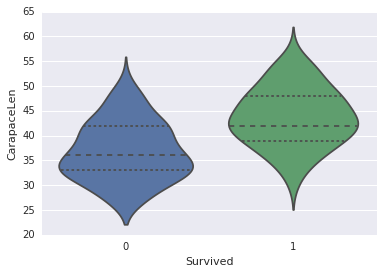

In [89]:
sns.violinplot (x="Survived", y="CarapaceLen",
                data=df_lobsters, inner="quart")

Although the classes are distinct in the aggregate, where the median carapace (outer shell) length is around 36 mm for the lobsters that died and 42 mm for those that survived, they are not cleanly separable.

## Notation

To develop some intuition and a method, let's now turn to a more general setting and work on synthetic data sets.

Let the data consist of $m$ data points, where each point is $d$-dimensional. Each dimension corresponds to some continuously-valued predictor. In addition, each data point will have a binary label, whose value is either 0 or 1.

Denote each point by an _augumented_ vector, $x_i$, such that

$$
\begin{array}{rcl}
  x_i
    & \equiv &
      \left(\begin{array}{c}
           1 \\
        x_{i,1} \\
        x_{i,2} \\
         \vdots \\
        x_{i,d}
      \end{array}\right)
      .
\end{array}
$$

That is, the point is the $d$ coordinates augmented by an initial dummy coordinate whose value is 1. This convention is similar to what we did in linear regression.

We can also stack these points as rows of a matrix, $X$, again, just as we did in regression:

$$
\begin{array}{rcl}
  X \equiv
    \left(\begin{array}{c}
      x_0^T \\
      x_1^T \\
      \vdots \\
      x_{m-1}^T
    \end{array}\right)
  & = &
    \left(\begin{array}{ccccc}
      1 & x_{0,1} & x_{0,2} & \cdots & x_{0,d} \\
      1 & x_{1,1} & x_{1,2} & \cdots & x_{1,d} \\
        &         &         & \vdots & \\
      1 & x_{m-1,1} & x_{m-1,2} & \cdots & x_{m-1,d} \\
    \end{array}\right).
\end{array}
$$

We will take the labels to be a binary column vector, $l \equiv \left(l_0, l_1, \ldots, l_{m-1}\right)^T$.

#### An example

We've pre-generated a synethetic data set consisting of labeled data points. Let's download and inspect it, first as a table and then visually.

In [90]:
df = pd.read_csv ('http://vuduc.org/cse6040/logreg_points_train.csv')

display (df.head ())
print "..."
display (df.tail ())

,x_1,x_2,label
0,-0.234443,-1.075960,1
1,0.730359,-0.918093,0
2,1.432270,-0.439449,0
3,0.026733,1.050300,0
4,1.879650,0.207743,0


...


,x_1,x_2,label
370,1.314300,0.746001,0
371,-0.759737,-0.042944,1
372,0.683560,-0.047791,0
373,0.774747,0.743837,0
374,0.899119,1.576390,0


Next, let's extract the coordinates as a Numpy matrix of `points` and the labels as a Numpy column vector `labels`. Mathematically, the `points` matrix corresponds to $X$ and the `labels` vector corresponds to $l$.

In [91]:
points = np.insert (df.as_matrix (['x_1', 'x_2']), 0, 1.0, axis=1)
labels = df.as_matrix (['label'])

print "First and last 5 points:\n", '='*23, '\n', points[:5], '\n...\n', points[-5:], '\n'
print "First and last 5 labels:\n", '='*23, '\n', labels[:5], '\n...\n', labels[-5:], '\n'

First and last 5 points:
[[ 1.        -0.234443  -1.07596  ]
 [ 1.         0.730359  -0.918093 ]
 [ 1.         1.43227   -0.439449 ]
 [ 1.         0.0267327  1.0503   ]
 [ 1.         1.87965    0.207743 ]] 
...
[[ 1.         1.3143     0.746001 ]
 [ 1.        -0.759737  -0.0429435]
 [ 1.         0.68356   -0.0477909]
 [ 1.         0.774747   0.743837 ]
 [ 1.         0.899119   1.57639  ]] 

First and last 5 labels:
[[1]
 [0]
 [0]
 [0]
 [0]] 
...
[[0]
 [1]
 [0]
 [0]
 [0]] 



Next, let's plot the data as a scatter plot using Plotly. To do so, we need to create separate traces, one for each cluster. Below, we've provided you with a function, `make_2d_scatter_traces()`, which does exactly that, given a labeled data set as a `(points, labels)` pair.

In [92]:
def assert_points_2d (points):
    """Checks the dimensions of a given point set."""
    assert type (points) is np.ndarray
    assert points.ndim == 2
    assert points.shape[1] == 3
    
def assert_labels (labels):
    """Checks the type of a given set of labels (must be integral)."""
    assert labels is not None
    assert (type (labels) is np.ndarray) or (type (labels) is list)

In [93]:
def extract_clusters (points, labels):
    """
    Given a list or array of labeled augmented points, this
    routine returns a pair of lists, (C[0:k], L[0:k]), where
    C[i] is an array of all points whose labels are L[i].
    """
    assert_points_2d (points)
    assert_labels (labels)

    id_label_pairs = list (enumerate (set (labels.flatten ())))
    labels_map = dict ([(v, i) for (i, v) in id_label_pairs])
    
    # Count how many points belong to each cluster
    counts = [0] * len (labels_map)
    for l in labels.flatten ():
        counts[labels_map[l]] += 1
        
    # Allocate space for each cluster
    clusters = [np.zeros ((k, 3)) for k in counts]
    
    # Separate the points by cluster
    counts = [0] * len (labels_map)
    for (x, l) in zip (points, labels.flatten ()):
        l_id = labels_map[l]
        k = counts[l_id]
        clusters[l_id][k, :] = x
        counts[l_id] += 1
        
    # Generate cluster labels
    cluster_labels = [None] * len (labels_map)
    for (l, i) in labels_map.items ():
        cluster_labels[i] = l
        
    return (clusters, cluster_labels)

In [94]:
def make_2d_scatter_traces (points, labels=None):
    """
    Given an augmented point set, possibly labeled,
    returns a list Plotly-compatible marker traces.
    """
    assert_points_2d (points)
    
    traces = []
    if labels is None:
        traces.append (Scatter (x=points[:, 1:2], y=points[:, 2:3], mode='markers'))
    else:
        assert_labels (labels)
        (clusters, cluster_labels) = extract_clusters (points, labels)
        for (c, l) in zip (clusters, cluster_labels):
            traces.append (Scatter (x=c[:, 1:2], y=c[:, 2:3],
                                    mode='markers',
                                    name="%s" % str (l)))
    return traces

In [95]:
print "Number of points:", len (points)

traces = make_2d_scatter_traces (points, labels)
py.iplot (traces)

Number of points: 375


PlotlyError: Aw, snap! You tried to use our API as the user 'Username', but the supplied API key doesn't match our records. You can view your API key at plot.ly/settings.

You're most likely getting this message because your local credentials file isn't synced with the Plotly server you're communicating with.

Go to plot.ly/<language>/getting-started (e.g., plot.ly/python/getting-started) for more information.

Make sure that you're logged in as Username.

Need help? Please try searching Plotly's <a href='http://stackoverflow.com/questions/tagged/plotly'>Stack Overflow channel</a>.

## Linear discriminants

Suppose you think that the _boundary_ between the two clusters may be represented by a line. For the synthetic data example above, I hope you'll agree that such a model is not a terrible one.

This line is referred to as a _linear discriminant_. Any point $x$ on this line may be described by $\theta^T x$, where $\theta$ is a vector of coefficients:

$$
\begin{array}{rcl}
  \theta
    & \equiv &
      \left(\begin{array}{c} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_d \end{array}\right)
      .
      \\
\end{array}
$$

For example, consider the case of 2-D points ($d=2$): the condition that $\theta^T x = 0$ means that

$$
\begin{array}{rrcl}
  &
  \theta^T x = 0
  & = & \theta_0 + \theta_1 x_1 + \theta_2 x_2 \\
  \implies
  & x_2
    & = & -\frac{\theta_0}{\theta_2} - \frac{\theta_1}{\theta_2} x_1.
\end{array}
$$

So that describes points _on_ the line. However, given _any_ point $x$ in the $d$-dimensional space that is _not_ on the line, $\theta^T x$ still produces a value: that value will be positive on one side of the line ($\theta^T x > 0$) or negative on the other ($\theta^T x < 0$).

Consequently, here is one simple way to use the linear discriminant function $\theta^T x$ to generate a label: just reinterpret its sign! In more mathematical terms, the function that converts, say, a positive value to the label "1" and all other values to the label "0" is called the _heaviside function_:

$$
\begin{array}{rcl}
  H(y) & \equiv & \left\{\begin{array}{ll}
      1 & \mathrm{if}\ y > 0
      \\
      0 & \mathrm{if}\ y \leq 0
    \end{array}\right..
\end{array}
$$

**Exercise.** This exercise has three parts.

_1)_ Given the a $m \times (d+1)$ matrix of augmented points (i.e., the $X$ matrix) and the vector $\theta$, implement a function to compute the value of the linear discriminant at each point. That is, the function should return a (column) vector $y$ where the $y_i = \theta^T x_i$.

_2)_ Implement the heaviside function, $H(y)$. Your function should allow for an arbitrary _matrix_ of input values, and should apply the heaviside function elementwise.

> Hint: Consider what Numpy's [`sign()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.sign.html) function produces, and transform the result accordingly.

_3)_ For the synthetic data you loaded above, determine a value of $\theta$ for which $H(\theta^T x)$ "best" separates the two clusters. To help you out, we've provided some Plotly code that draws the discriminant boundary and also applies $H(\theta^T x)$ to each point, coloring the point by whether it is correctly classified. (The code also prints the number of correcty classified points.) So, you just need to try different values of $\theta$ until you find something that is "close."

> Hint: We found a line that commits just 5 errors, out of 375 possible points.

In [146]:
import numpy as np
def lin_discr (X, theta):
    print "lin_discr X: ", np.array(X).shape
    print "lin_discr theta: ", np.array(theta).shape
    #print np.inner(theta.T, X)
    return X.dot(theta)
    # @YOUSE: Part 1 -- Complete this function.


def heaviside (Y):

    return np.array([1 if c>0 else 0 for c in Y]).reshape(-1,1)
    #return [ 1.0 if item > 0 else 0 for item in Y]
    


> The following is the code to generate the plot; look for the place to try different values of $\theta$ a couple of code cells below.

In [147]:
def heaviside_int (Y):
    """Evaluates the heaviside function, but returns integer values."""
    return heaviside (Y).astype (dtype=int)

def assert_discriminant (theta, d=2):
    """
    Verifies that the given coefficients correspond to a
    d-dimensional linear discriminant ($\theta$).
    """
    assert len (theta) == (d+1)
    
def gen_lin_discr_labels (points, theta, fun=heaviside_int):
    """
    Given a set of points and the coefficients of a linear
    discriminant, this function returns a set of labels for
    the points with respect to this discriminant.
    """
    assert_points_2d (points)
    assert_discriminant (theta)
    
    score = lin_discr (points, theta)
    labels = fun (score)
    return labels

In [148]:
def gen_lin_discr_trace (points, theta, name='Discriminant'):
    """
    Given a set of points and the coefficients of a linear
    discriminant, this function returns a set of Plotly
    traces that show how the points are classified as well
    as the location of the discriminant boundary.
    """
    assert_points_2d (points)
    assert_discriminant (theta)
    
    x1 = [min (points[:, 1]), max (points[:, 1])]
    m = -theta[1] / theta[2]
    b = -theta[0] / theta[2]
    x2 = [(b + m*x) for x in x1]
        
    return Scatter (x=x1, y=x2, mode='lines', name=name)

In [149]:
def np_row_vec (init_list):
    """Generates a Numpy-compatible row vector."""
    return np.array (init_list, order='F', ndmin=2)

def np_col_vec (init_list):
    """Generates a Numpy-compatible column vector."""
    return np_row_vec (init_list).T

In [150]:
def gen_labels_part3 (points, labels, theta):
    your_labels = gen_lin_discr_labels (points, theta)
    return (labels == your_labels)

In [151]:
# @YOUSE: Part 3 -- Select parameters for theta!
#theta = np_col_vec ([0., -1., 3.])
theta = np_col_vec ([ -3.76460171, -15.62953171,  -3.04238984])

# Generate 0/1 labels for your discriminant:
is_correct = gen_labels_part3 (points, labels, theta)
print is_correct
print "Number of misclassified points:", (len (points) - sum (is_correct))[0]
print "\n(Run the code cell below to visualize the results.)"

lin_discr X:  (375, 3)
lin_discr theta:  (3, 1)
[[ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True

In [102]:
# Visually inspect the above results
traces = make_2d_scatter_traces (points, is_correct)
traces.append (gen_lin_discr_trace (points, theta))

# Plot it!
layout = Layout (xaxis=dict (range=[-1.25, 2.25]),
                 yaxis=dict (range=[-3.25, 2.25]))
fig = Figure (data=traces, layout=layout)
py.iplot (fig)

PlotlyError: Aw, snap! You tried to use our API as the user 'Username', but the supplied API key doesn't match our records. You can view your API key at plot.ly/settings.

You're most likely getting this message because your local credentials file isn't synced with the Plotly server you're communicating with.

Go to plot.ly/<language>/getting-started (e.g., plot.ly/python/getting-started) for more information.

Make sure that you're logged in as Username.

Need help? Please try searching Plotly's <a href='http://stackoverflow.com/questions/tagged/plotly'>Stack Overflow channel</a>.

## An alternative linear discriminant: the logistic or "sigmoid" function

The heaviside function, $H(\theta^T x)$, enforces a sharp boundary between classes around the $\theta^T x=0$ line. The following code produces a [contour plot](https://plot.ly/python/contour-plots/) to show this effect.

In [103]:
# Use Numpy's handy meshgrid() to create a regularly-spaced grid of values.
# http://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html

x1 = np.linspace (-2., +2., 100)
x2 = np.linspace (-2., +2., 100)
x1_grid, x2_grid = np.meshgrid (x1, x2)
h_grid = heaviside (theta[0] + theta[1]*x1_grid + theta[2]*x2_grid)

trace_grid = Contour (x=x1, y=x2, z=h_grid)
py.iplot ([trace_grid])

PlotlyError: Aw, snap! You tried to use our API as the user 'Username', but the supplied API key doesn't match our records. You can view your API key at plot.ly/settings.

You're most likely getting this message because your local credentials file isn't synced with the Plotly server you're communicating with.

Go to plot.ly/<language>/getting-started (e.g., plot.ly/python/getting-started) for more information.

Make sure that you're logged in as Username.

Need help? Please try searching Plotly's <a href='http://stackoverflow.com/questions/tagged/plotly'>Stack Overflow channel</a>.

However, as the lobsters example suggests, real data are not likely to be cleanly separable, especially when the number of features we have at our disposal is relatively small.

Since the labels are binary, a natural idea is to give the classification problem a probabilistic interpretation. The _logistic function_ provides at least one way to do so:

$$
\begin{array}{rcl}
  G(y) & \equiv & \frac{1}{1 + e^{-y}}
\end{array}
$$

> This function is also sometimes called the _logit_ or _sigmoid_ function.

The logistic function takes any value in the range $(-\infty, +\infty)$ and produces a value in the range $(0, 1)$. Thus, given a value $x$, we can interpret it as a conditional probability that the label is 1.

**Exercise.** Consider a set of 1-D points generated by a _mixture of Gaussians_. That is, suppose that there are two Gaussian distributions over the 1-dimensional variable, $x \in (-\infty, +\infty)$, that have the _same_ variance ($\sigma^2$) but _different_ means ($\mu_0$ and $\mu_1$). Show that the conditional probability of observing a point labeled "1" given $x$ may be written as,

$$\mathrm{Pr}\left[l=1\,|\,x\right]
    \propto \displaystyle \frac{1}{1 + e^{-(\theta_0 + \theta_1 x)}},$$

for a suitable definition of $\theta_0$ and $\theta_1$. To carry out this computation, recall _Bayes's rule (also: Bayes's theorem)_:

$$
\begin{array}{rcl}
  \mathrm{Pr}[l=1\,|\,x]
    & = &
      \dfrac{\mathrm{Pr}[x\,|\,l=1] \, \mathrm{Pr}[l=1]}
            {\mathrm{Pr}[x\,|\,l=0] \, \mathrm{Pr}[l=0]
             + \mathrm{Pr}[x\,|\,l=1] \, \mathrm{Pr}[l=1]
            }.
\end{array}
$$

You may assume the prior probabilities of observing a 0 or 1 are given by $\mathrm{Pr}[l=0] \equiv p_0$ and $\mathrm{Pr}[l=1] \equiv p_1$.

> Time and interest permitting, we'll solve this exercise on the whiteboard.

**Exercise.** Implement the logistic function. Inspect the resulting plot of $G(y)$ in 1-D and then the contour plot of $G(\theta^T{x})$. Your function should accept a Numpy matrix of values, `Y`, and apply the sigmoid elementwise.

In [104]:
def logistic (Y):

    return 1.0/(1+np.exp(-Y))
    # @YOUSE: Implement the logistic function G(y) here
    pass

> Plot of your implementation in 1D:

In [105]:
x_logit_1d = np.linspace (-6.0, +6.0, 101)
y_logit_1d = logistic (x_logit_1d)

trace_logit_1d = Scatter (x=x_logit_1d, y=y_logit_1d)
py.iplot ([trace_logit_1d])

PlotlyError: Aw, snap! You tried to use our API as the user 'Username', but the supplied API key doesn't match our records. You can view your API key at plot.ly/settings.

You're most likely getting this message because your local credentials file isn't synced with the Plotly server you're communicating with.

Go to plot.ly/<language>/getting-started (e.g., plot.ly/python/getting-started) for more information.

Make sure that you're logged in as Username.

Need help? Please try searching Plotly's <a href='http://stackoverflow.com/questions/tagged/plotly'>Stack Overflow channel</a>.

> Contour plot of your function:

In [106]:
g_grid = logistic (theta[0] + theta[1]*x1_grid + theta[2]*x2_grid)
print g_grid
trace_logit_grid = Contour (x=x1, y=x2, z=g_grid)
py.iplot ([trace_logit_grid])

[[  1.79862100e-02   1.72862916e-02   1.66131492e-02 ...,   3.63563877e-04
    3.49172254e-04   3.35350130e-04]
 [  2.02570397e-02   1.94705060e-02   1.87139282e-02 ...,   4.10395070e-04
    3.94150372e-04   3.78548446e-04]
 [  2.28079118e-02   2.19245501e-02   2.10746635e-02 ...,   4.63255861e-04
    4.44919703e-04   4.27308998e-04]
 ..., 
 [  9.99572691e-01   9.99555080e-01   9.99536744e-01 ...,   9.78925337e-01
    9.78075450e-01   9.77192088e-01]
 [  9.99621452e-01   9.99605850e-01   9.99589605e-01 ...,   9.81286072e-01
    9.80529494e-01   9.79742960e-01]
 [  9.99664650e-01   9.99650828e-01   9.99636436e-01 ...,   9.83386851e-01
    9.82713708e-01   9.82013790e-01]]


PlotlyError: Aw, snap! You tried to use our API as the user 'Username', but the supplied API key doesn't match our records. You can view your API key at plot.ly/settings.

You're most likely getting this message because your local credentials file isn't synced with the Plotly server you're communicating with.

Go to plot.ly/<language>/getting-started (e.g., plot.ly/python/getting-started) for more information.

Make sure that you're logged in as Username.

Need help? Please try searching Plotly's <a href='http://stackoverflow.com/questions/tagged/plotly'>Stack Overflow channel</a>.

**Exercise.** Verify the following properties of the logistic function, $G(y)$.

$$
\begin{array}{rcll}
  G(y)
    & = & \frac{e^y}{e^y + 1}
    & \mathrm{(P1)} \\
  G(-y)
    & = & 1 - G(y)
    & \mathrm{(P2)} \\
  \dfrac{dG}{dy}
    & = & G(y) G(-y)
    & \mathrm{(P3)} \\
  {\dfrac{d}{dy}} {\left[ \ln G(y) \right]}
    & = & G(-y)
    & \mathrm{(P4)} \\
  {\dfrac{d}{dy}} {\ln \left[ 1 - G(y) \right]}
    & = & -G(y)
    & \mathrm{(P5)}
\end{array}
$$

## Determining $\theta$ via Maximum Likelihood Estimation

Previously, you determined $\theta$ for our synthetic dataset experimentally. Can you compute a good $\theta$ automatically? One of the standard techniques in statistics is to perform a _maximum likelihood estimation_ (MLE) of a model's parameters, $\theta$.

Indeed, MLE is basis for the "statistical" way to derive the normal equations in the case of linear regression, though that is of course not how we encountered it in this class.

#### "Likelihood" as an objective function

MLE derives from the following idea. Consider the joint probability of observing all of the labels, given the points and the parameters, $\theta$:

$$
  \mathrm{Pr}[l\,|\,X, \theta].
$$

Suppose these observations are independent and identically distributed (i.i.d.). Then the joint probability can be factored as the product of individual probabilities,

$$
\begin{array}{rcl}
  \mathrm{Pr}[l\,|\,X,\theta] = \mathrm{Pr}[l_0, \ldots, l_{m-1}\,|\,x_0, \ldots, x_{m-1}, \theta]
  & = & \mathrm{Pr}[l_0\,|\,x_0, \theta] \cdots \mathrm{Pr}[l_{m-1}\,|\,x_{m-1}, \theta] \\
  & = & \displaystyle \prod_{i=0}^{m-1} \mathrm{Pr}[l_i\,|\,x_i,\theta].
\end{array}
$$

The maximum likelihood principle says that you should try to choose a parameter $\theta$ that maximizes the chances ("likelihood") of seeing these particular observations. Thus, we can simply reinterpret the preceding probability as an objective function to optimize. Mathematically, it is equivalent and convenient to consider the logarithm of the likelihood, or _log-likelihood_, as the objective function, defining it by,

$$
\begin{array}{rcl}
  \mathcal{L}(\theta; l, X)
    & \equiv &
      \log \left\{ \displaystyle \prod_{i=0}^{m-1} \mathrm{Pr}[l_i\,|\,x_i,\theta] \right\} \\
    & = &
      \displaystyle \sum_{i=0}^{m-1} \log \mathrm{Pr}[l_i\,|\,x_i,\theta].
\end{array}
$$

> We are using the symbol $\log$, which could be taken in any convenient base, such as the natural logarithm ($\ln y$) or the information theoretic base-two logarithm ($\log_2 y$).

The MLE procedure then consists of two steps:

* For the problem at hand, determine a suitable choice for $\mathrm{Pr}[l_i\,|\,x_i,\theta]$.
* Run any optimization procedure to find the $\theta$ that maximizes $\mathcal{L}(\theta; l, X)$.

#### Example: Logistic regression

Let's say you have decided that the logistic function, $G(\theta^T x_i)$, is a good model of the probability of producing a label $l_i$ given the point $x_i$. Under the i.i.d. assumption, we can interpret the label $l_i$ as being the result of a [Bernoulli trial](https://en.wikipedia.org/wiki/Bernoulli_trial) (e.g., a biased coin flip), where the probability of success ($l_i=1$) is defined as $g_i = g_i(\theta) \equiv G(\theta^T x_i)$. Thus,

$$
\begin{array}{rcl}
  \mathrm{Pr}[l_i \, | \, x_i, \theta]
    & \equiv & g_i^{l_i} \cdot \left(1 - g_i\right)^{1 - l_i}.
\end{array}
$$

The log-likelihood in turn becomes,

$$
\begin{array}{rcl}
  \mathcal{L}(\theta; l, X)
    & = & \displaystyle
      \sum_{i=0}^{m-1} l_i \log g_i + (1-l_i) \log (1-g_i) \\
    & = &
      l^T \log g + (1-l)^T \log (1-g),
\end{array}
$$

where $g \equiv (g_0, g_1, \ldots, g_{m-1})^T$.

#### Optimizing the log-likelihood via gradient (steepest) ascent

To optimize the log-likelihood with respect to the parameters, $\theta$, you'd like to do the moral equivalent of taking its derivative, setting it to zero, and then solving for $\theta$.

For example, recall that in the case of linear regression via least squares minimization, carrying out this process produced an _analytic_ solution for the parameters, which was to solve the normal equations.

Unfortunately, for logistic regression---or for most log-likelihoods you are likely to ever write down---you _cannot_ usually derive an analytic solution. Therefore, you will need to resort to numerical optimization procedures.

The simplest such procedure is _gradient ascent_ (or _steepest ascent_), in the case of maximizing some function; if instead you are minimizing the function, then the equivalent procedure is gradient (steepest) _descent_. The idea is to start with some guess, compute the derivative of the objective function at that guess, and then move in the direction of steepest descent. As it happens, the direction of steepest descent is given by the gradient. More formally, the procedure applied to the log-likelihood is:

* Start with some initial guess, $\theta(0)$.
* At each iteration $t \geq 0$ of the procedure, let $\theta(t)$ be the current guess.
* Compute the direction of steepest descent by evaluating the gradient, $\Delta_t \equiv \nabla_{\theta(t)} \left\{\mathcal{L}(\theta(t); l, X)\right\}$.
* Take a step in the direction of the gradient, $\theta(t+1) \leftarrow \theta(t) + \phi \Delta_t$, where $\phi$ is a suitably chosen fudge factor.

This procedure should smell eerily like the one in [Lab 24](http://nbviewer.ipython.org/github/rvuduc/cse6040-ipynbs/blob/master/24--online-linreg.ipynb)! And just as in Lab 24, the tricky bit is how to choose $\phi$, the principled choice of which we will defer until another lab.

> One additional and slight distinction between this procedure and the Lab 24 procedure is that here we are optimizing using the full dataset, rather than processing data points one at a time. (That is, the step iteration variable $t$ used above is not used in exactly the same way as the step iteration $k$ was used in Lab 24.)
>
> Another question is, how do we know this procedure will converge to the global maximum, rather than, say, a local maximum? For that you need a deeper analysis of a specific $\mathcal{L}(\theta; l, X)$, to show, for instance, that it is convex in $\theta$.

#### Example: A gradient ascent algorithm for logistic regression

Let's apply the gradient ascent procedure to the logistic regression problem, in order to determine a good $\theta$.

**Exercise.** Show the following:

$$
\begin{array}{rcl}
  \nabla_\theta \left\{\mathcal{L}(\theta; l, X)\right\}
    & = & X^T \left[ l - G(X \cdot \theta)\right].
\end{array}
$$

**Exercise.** Implement the gradient ascent procedure to determine $\theta$, and try it out on the sample data.

> In your solution, we'd like you to store *all* guesses in the matrix `thetas`, so that you can later see how the $\theta(t)$ values evolve. To extract a particular column `t`, use the notation, `theta[:, t:t+1]`. This notation is necessary to preserve the "shape" of the column as a column vector.

In [152]:
MAX_STEP = 1000
PHI = 0.1

# Get the data coordinate matrix, X, and labels vector, l
X = points
l = labels.astype (dtype=float)


# Store *all* guesses, for subsequent analysis
thetas = np.zeros ((3, MAX_STEP+1))

for t in range (MAX_STEP):

    y_logit = logistic (np.inner(thetas.T[t], X))
    y_logit = np.reshape(y_logit, (-1,1))
    #print y_logit
    #print l
    assert y_logit.shape == l.shape
    delta = np.inner(X.T,(l - y_logit).reshape(1,-1))

    step = PHI*delta

    thetas.T[t + 1] = thetas.T[t] + step.reshape(1,-1)

    # @YOUSE: Fill in this code
    pass
    
print "Your (hand) solution:", theta.T.flatten ()
print "Computed solution:", thetas[:, MAX_STEP]

Your (hand) solution: [ -3.76460171 -15.62953171  -3.04238984]
Computed solution: [ -3.76460171 -15.62953171  -3.04238984]


In [153]:
theta_mle = thetas[:, MAX_STEP:]

# Generate 0/1 labels for computed discriminant:
is_correct_mle = gen_labels_part3 (points, labels, theta_mle)

print "Number of misclassified points using MLE:", (len (points) - sum (is_correct_mle))[0]
print "\n(Run the code cell below to visualize the results.)"

lin_discr X:  (375, 3)
lin_discr theta:  (3, 1)
Number of misclassified points using MLE: 6

(Run the code cell below to visualize the results.)


In [154]:
# Visually inspect the above results
traces_mle = make_2d_scatter_traces (points, is_correct_mle)
traces_mle.append (gen_lin_discr_trace (points, theta_mle))

# Plot it!
layout_mle = Layout (xaxis=dict (range=[-1.25, 2.25]),
                     yaxis=dict (range=[-3.25, 2.25]))
fig_mle = Figure (data=traces_mle, layout=layout_mle)
py.iplot (fig_mle)

PlotlyError: Aw, snap! You tried to use our API as the user 'Username', but the supplied API key doesn't match our records. You can view your API key at plot.ly/settings.

You're most likely getting this message because your local credentials file isn't synced with the Plotly server you're communicating with.

Go to plot.ly/<language>/getting-started (e.g., plot.ly/python/getting-started) for more information.

Make sure that you're logged in as Username.

Need help? Please try searching Plotly's <a href='http://stackoverflow.com/questions/tagged/plotly'>Stack Overflow channel</a>.

**Exercise.** Make a contour plot of the log-likelihood and draw the trajectory taken by the $\theta(t)$ values laid on top of it.

In [155]:
def log_likelihood (theta, l, X):
    g = logistic(np.inner(theta, X))
    return np.sum(l.dot(np.log(g).reshape(1,-1)) + (1-l).dot(np.log(1-g).reshape(1,-1)))

    # @YOUSE: Complete this function to evaluate the log-likelihood
    pass

In [156]:
n1_ll = 100
x1_ll = np.linspace (-20., 0., n1_ll)
n2_ll = 100
x2_ll = np.linspace (-20., 0., n2_ll)
x1_ll_grid, x2_ll_grid = np.meshgrid (x1_ll, x2_ll)

ll_grid = np.zeros ((n1_ll, n2_ll))

print x1_ll_grid
print x2_ll_grid
# @YOUSE: Write some code to compute ll_grid, which the following code cell visualizes

[[-20.        -19.7979798 -19.5959596 ...,  -0.4040404  -0.2020202   0.       ]
 [-20.        -19.7979798 -19.5959596 ...,  -0.4040404  -0.2020202   0.       ]
 [-20.        -19.7979798 -19.5959596 ...,  -0.4040404  -0.2020202   0.       ]
 ..., 
 [-20.        -19.7979798 -19.5959596 ...,  -0.4040404  -0.2020202   0.       ]
 [-20.        -19.7979798 -19.5959596 ...,  -0.4040404  -0.2020202   0.       ]
 [-20.        -19.7979798 -19.5959596 ...,  -0.4040404  -0.2020202   0.       ]]
[[-20.        -20.        -20.        ..., -20.        -20.        -20.       ]
 [-19.7979798 -19.7979798 -19.7979798 ..., -19.7979798 -19.7979798
  -19.7979798]
 [-19.5959596 -19.5959596 -19.5959596 ..., -19.5959596 -19.5959596
  -19.5959596]
 ..., 
 [ -0.4040404  -0.4040404  -0.4040404 ...,  -0.4040404  -0.4040404
   -0.4040404]
 [ -0.2020202  -0.2020202  -0.2020202 ...,  -0.2020202  -0.2020202
   -0.2020202]
 [  0.          0.          0.        ...,   0.          0.          0.       ]]


In [157]:
trace_ll_grid = Contour (x=x1_ll, y=x2_ll, z=ll_grid)
trace_thetas = Scatter (x=thetas[1, :], y=thetas[2, :], mode='markers+lines')
py.iplot ([trace_ll_grid, trace_thetas])

PlotlyError: Aw, snap! You tried to use our API as the user 'Username', but the supplied API key doesn't match our records. You can view your API key at plot.ly/settings.

You're most likely getting this message because your local credentials file isn't synced with the Plotly server you're communicating with.

Go to plot.ly/<language>/getting-started (e.g., plot.ly/python/getting-started) for more information.

Make sure that you're logged in as Username.

Need help? Please try searching Plotly's <a href='http://stackoverflow.com/questions/tagged/plotly'>Stack Overflow channel</a>.

In [159]:

for t in range (len(thetas.T)):
    print thetas.T[t], 
    print log_likelihood(thetas.T[t], l, X)

[ 0.  0.  0.] -97473.8222661
[ -0.75       -11.86273821 -11.61870068] -inf
[ -3.44276799 -13.56919967  -7.87552928] -972126.718703
[ -3.89746766 -14.24647417  -5.98164383] -906345.280932
[ -3.78734501 -14.5635754   -5.09652978] -878144.638196
[ -3.66061505 -14.74945647  -4.55738139] -861234.967494
[ -3.58939897 -14.85894642  -4.19383585] -849369.973602
[ -3.56046665 -14.92624219  -3.92813912] -840236.223554
[ -3.55463203 -14.97002842  -3.72414897] -832922.078753
[ -3.55945464 -15.00026512  -3.56344632] -826996.707843
[ -3.56798991 -15.02238852  -3.43552435] -822208.811002
[ -3.57674167 -15.03943638  -3.33360188] -818377.736905
[ -3.58422667 -15.0531381   -3.2527501 ] -815352.488621
[ -3.59005373 -15.06450195  -3.1890541 ] -812998.091683
[ -3.59435431 -15.07414043  -3.13925569] -811193.050987
[ -3.59745187 -15.08245023  -3.10060924] -809830.317132
[ -3.5996898  -15.08970903  -3.07081744] -808818.333527
[ -3.60135752 -15.09612556  -3.04798699] -808081.016133
[ -3.60267083 -15.1018646   -

In [190]:
def log_likelihood (theta, l, X):
    g = logistic(np.inner(theta, X))
    #return np.sum(l.dot(np.log(g).reshape(1,-1)) + (1-l).dot(np.log(1-g).reshape(1,-1)))
    u = np.ones([X.shape[0]])

    return l.T.dot(X).dot(theta) + u.T.dot(logistic(-1 * X.dot(theta)))

In [191]:

for t in range (len(thetas.T)):
    print thetas.T[t],
    print log_likelihood(thetas.T[t], l, X)

[ 0.  0.  0.] [ 187.5]
[ -0.75       -11.86273821 -11.61870068] [ 3305.56602465]
[ -3.44276799 -13.56919967  -7.87552928] [ 2308.80172053]
[ -3.89746766 -14.24647417  -5.98164383] [ 1944.69480337]
[ -3.78734501 -14.5635754   -5.09652978] [ 1830.18160551]
[ -3.66061505 -14.74945647  -4.55738139] [ 1769.82518124]
[ -3.58939897 -14.85894642  -4.19383585] [ 1725.02551091]
[ -3.56046665 -14.92624219  -3.92813912] [ 1687.00436993]
[ -3.55463203 -14.97002842  -3.72414897] [ 1654.19505501]
[ -3.55945464 -15.00026512  -3.56344632] [ 1626.29900375]
[ -3.56798991 -15.02238852  -3.43552435] [ 1603.09237897]
[ -3.57674167 -15.03943638  -3.33360188] [ 1584.21110026]
[ -3.58422667 -15.0531381   -3.2527501 ] [ 1569.15883382]
[ -3.59005373 -15.06450195  -3.1890541 ] [ 1557.36877876]
[ -3.59435431 -15.07414043  -3.13925569] [ 1548.26807127]
[ -3.59745187 -15.08245023  -3.10060924] [ 1541.3258726]
[ -3.5996898  -15.08970903  -3.07081744] [ 1536.08053363]
[ -3.60135752 -15.09612556  -3.04798699] [ 1532.14